In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-1

# Masses of the two bodies (in kilograms)
m1 = 5.972e24  # Earth
m2 = 7.348e22  # Moon

# Initial positions (in meters)
r1_0 = np.array([0, 0, 0])  # Earth at origin
r2_0 = np.array([384400e3, 0, 0])  # Moon 384,400 km away from Earth

# Initial velocities (in meters per second)
v1_0 = np.array([0, 0, 0])
v2_0 = np.array([0, 1022, 0])  # Moon's orbital velocity

# Initial state vector: [r1_x, r1_y, v1_x, v1_y, r2_x, r2_y, v2_x, v2_y]
initial_state = np.concatenate((r1_0, v1_0, r2_0, v2_0))


In [3]:
def derivatives(state):
    # Unpack the state vector
    r1 = state[0:3]
    v1 = state[3:6]
    r2 = state[6:9]
    v2 = state[9:12]

    # Compute the distance vector and its magnitude
    r = r2 - r1
    distance = np.linalg.norm(r)

    # Compute the gravitational force
    force = G * m1 * m2 / distance**2

    # Compute the accelerations
    a1 = force / m1 * r / distance
    a2 = -force / m2 * r / distance

    # Return the derivatives of the state vector
    return np.concatenate((v1, a1, v2, a2))


In [4]:
def rk4_step(f, y, t, dt):
    k1 = f(y)
    k2 = f(y + 0.5 * dt * k1)
    k3 = f(y + 0.5 * dt * k2)
    k4 = f(y + dt * k3)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_ode(f, y0, t_span, dt):
    t0, t_end = t_span
    t_values = np.arange(t0, t_end, dt)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0

    for i in range(1, len(t_values)):
        y_values[i] = rk4_step(f, y_values[i-1], t_values[i-1], dt)

    return t_values, y_values


In [5]:
# Time span (in seconds)
t_span = (0, 3600*24*30)  # One month

# Time step (in seconds)
dt = 3600  # 1 hour

# Solve the differential equations
t_values, y_values = solve_ode(derivatives, initial_state, t_span, dt)


In [6]:
y_values.shape

(720, 12)

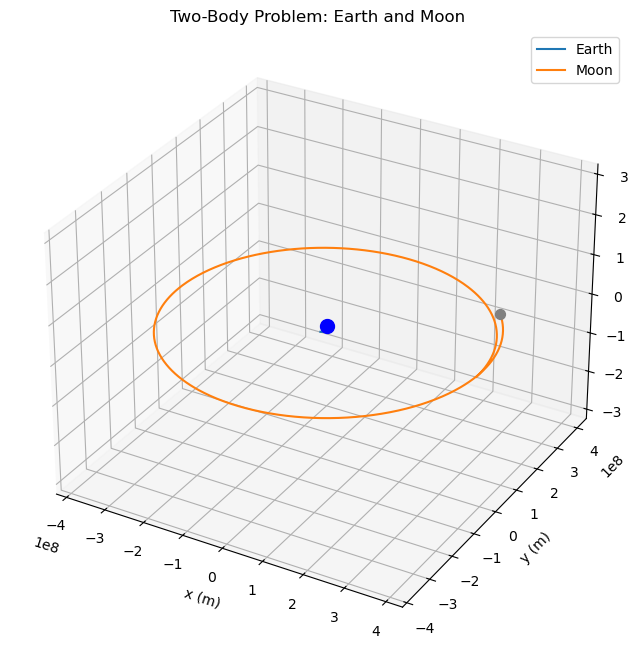

In [22]:
r1_sol = y_values[:, 0:3]
r2_sol = y_values[:, 6:9]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")


ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:,2], label='Earth')
ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:,2], label='Moon')
ax.scatter([r1_sol[-1,0]], [r1_sol[-1,1]], [r1_sol[-1,2]], color='blue', s=100)
ax.scatter([r2_sol[-1,0]], [r2_sol[-1,1]], [r2_sol[-1,2]], color='gray', s=50)
ax.legend()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_title('Two-Body Problem: Earth and Moon')
ax.grid()
ax.axis('equal')
plt.show()


In [10]:
from mayavi import mlab

In [19]:
#TODO: Add comments for documentation for mayavi 3d renders
mlab.figure(size=(800,800), bgcolor=(1,1,1))

earth = mlab.points3d(r1_sol[0,0], r1_sol[0,1], r1_sol[0,2], scale_factor=3.371e6, color=(0,0,1), resolution=50, name="Earth")
moon = mlab.points3d(r2_sol[0,0], r2_sol[0,1], r2_sol[0,2], scale_factor=1.737e6, color=(0.5,0.5,0.5), resolution=50, name="Moon")

earth_traj = mlab.plot3d(r1_sol[:1,0], r1_sol[:1,1], r1_sol[:1,2], color=(0,0,1), tube_radius=None, line_width=1, representation="wireframe", name="Earth Trajectory")
moon_traj = mlab.plot3d(r2_sol[:1,0], r2_sol[:1,1], r2_sol[:1,2], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, representation="wireframe", name="Moon Trajectory")

@mlab.animate(delay=100)
def animate():
    for i in range(1, len(t_values)):
        earth.mlab_source.set(x=r1_sol[i,0], y=r1_sol[i,1], z=r1_sol[i,2])
        moon.mlab_source.set(x=r2_sol[i,0], y=r2_sol[i,1], z=r2_sol[i,2])
        earth_traj.mlab_source.set(x=r1_sol[i:i+1,0], y=r1_sol[i:i+1,1], z=r1_sol[i:i+1,2])
        moon_traj.mlab_source.set(x=r2_sol[i:i+1,0], y=r2_sol[i:i+1,1], z=r2_sol[i:i+1,2])
        yield

mlab.axes(xlabel="x (m)", ylabel="y (m)", zlabel="z (m)", ranges=[-4e8, 4e8, -4e8, 4e8, -4e8, 4e8])

animate()
mlab.show()